In [1]:
import logging
import pathlib
import pickle
import warnings

import attr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

# from skrough.bireducts.dynamically_adapted_approximate_bireduct import DynamicallyAdaptedApproximateBireduct
# from skrough.base import Bireduct
from joblib import Parallel, delayed
from sklearn.metrics import auc, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import config

In [4]:
DATA_DIR = pathlib.Path(config.DATA_DIR)
TMP_DIR = pathlib.Path(config.TMP_DIR)
N_JOBS = 7
SEP = ";"

K_NEIGHBORS_PROCESSES = 40
N_BIREDUCTS = 1000
BIREDUCT_ALLOWED_RANDOMNESS = 0.05
BIREDUCT_CANDIDATE_N_ATTRS = 100

# FILEPATH_IN = DATA_DIR / 'toolbox_tabular_data_annonymized_discretized_uniform.csv'
# FILEPATH_IN = DATA_DIR / 'toolbox_tabular_data_annonymized_discretized_quantile.csv'
FILEPATH_IN = DATA_DIR / "toolbox_tabular_data_annonymized_discretized_kmeans.csv"
EMBEDDINGS_FILEPATH_IN = DATA_DIR / "process_embeddings_d50.csv"


FILENAME_OUT_TEMPLATE = "daab_leave_one_process_out_k_{k}_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_quantile.csv"
FILENAME_2_OUT_TEMPLATE = "daab_leave_one_process_out_same_category_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_quantile.csv"

# FILENAME_OUT_TEMPLATE = 'daab_draw_uni_dec_leave_one_process_out_k_{k}_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_kmeans.csv'
# FILENAME_2_OUT_TEMPLATE = 'daab_draw_uni_dec_leave_one_process_out_same_category_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_kmeans.csv'

In [3]:
logging.basicConfig(filename=TMP_DIR / "b.log", level=logging.INFO)

In [8]:
df = pd.read_csv(FILEPATH_IN, sep=SEP)
process_ids = df.pop("process_ids")
df = df.astype("category")
df = df.apply(lambda x: x.cat.codes)
df_dec = df.pop("target")


embeddings = pd.read_csv(EMBEDDINGS_FILEPATH_IN)
process_category = embeddings[["process_ids", "process_category"]]
embeddings.drop(["process_category"], axis=1, inplace=True)
embeddings.set_index("process_ids", inplace=True)
emb_nbrs = NearestNeighbors().fit(embeddings)

In [ ]:
process_ids = df.pop("process_ids")
df = df.astype("category")
df = df.apply(lambda x: x.cat.codes)
df_dec = df.pop("target")


embeddings = pd.read_csv(EMBEDDINGS_FILEPATH_IN)
process_category = embeddings[["process_ids", "process_category"]]
embeddings.drop(["process_category"], axis=1, inplace=True)
embeddings.set_index("process_ids", inplace=True)
emb_nbrs = NearestNeighbors().fit(embeddings)

In [ ]:
# test = pd.DataFrame([
#                 [0, 1, 222, 1, 2],
#                 [0, 1, 100, 1, 3],
#                 [0, 1, 333, 1, 2],
#                 [1, 1, 222, 1, 2],
# ], columns=['c0','c1','c2','c3','c4'])

In [ ]:
# train = pd.DataFrame([
#                 [0, 1, 1, 1, 2],
#                 [0, 1, 1, 1, 3],
#                 [0, 1, 1, 1, 2],
#                 [1, 1, 1, 1, 3],
#                 [1, 1, 1, 1, 2],
#                 [0, 1, 1, 1, 3],
#                 [0, 1, 1, 1, 3],
#                 [0, 1, 1, 1, 3],
#                 [0, 1, 1, 1, 3],
#                 [0, 1, 1, 1, 3],
# ], columns=['c0','c1','c2','c3','c4'])

In [ ]:
# objs = [0,1,2,3,4,5,6,7]
# cols = [0,1,4]
# bireduct_train = train.iloc[objs, cols]
# bireduct_train.drop_duplicates(inplace=True)
# bireduct_train.index[3]

In [ ]:
# nn = NearestNeighbors().fit(bireduct_train)

In [ ]:
# dist, neighbors = nn.kneighbors(test.iloc[:, cols], n_neighbors=1, return_distance=True)
# [bireduct_train.index[n[0]] if d[0] == 0 else np.nan for d, n in zip(dist, neighbors)]

In [ ]:
# dist

In [5]:
def refine_train(train, test, process_ids, embeddings, emb_nbrs, k):
    # search for k+1 neighbors because the one we search for is obviously the best match (thus +1)
    test_process_id = process_ids.loc[test.index[0]]
    nbrs = emb_nbrs.kneighbors(
        [embeddings.loc[test_process_id]], n_neighbors=k + 1, return_distance=False
    )[0]
    return train[process_ids.loc[train.index].isin(embeddings.index[nbrs])]


def get_bireducts(
    train, df_dec, n_bireducts, bireduct_allowed_randomness, bireduct_candidate_n_attrs
):
    ghr = DynamicallyAdaptedApproximateBireduct(
        n_of_probes=100,
        allowed_randomness=bireduct_allowed_randomness,
        candidate_n_attrs=bireduct_candidate_n_attrs,
    )
    ghr.fit(train, df_dec.loc[train.index], check_data_consistency=False)
    #     bireducts = []
    #     for i in range(n_bireducts):
    #         bireducts.append(ghr.get_bireduct())
    bireducts = Parallel(n_jobs=N_JOBS)(
        delayed(ghr.get_bireduct)() for i in range(n_bireducts)
    )
    return bireducts


def predict(train, test, bireduct, df_dec):
    objs = bireduct.objects
    cols = bireduct.attributes
    bireduct_train = train.iloc[objs, cols]
    bireduct_train = bireduct_train.drop_duplicates()
    nn = NearestNeighbors().fit(bireduct_train)
    dist, neighbors = nn.kneighbors(
        test.iloc[:, cols], n_neighbors=1, return_distance=True
    )
    result = [
        df_dec.loc[bireduct_train.index[n[0]]] if d[0] == 0 else np.nan
        for d, n in zip(dist, neighbors)
    ]
    return result


def fit_predict(
    train,
    test,
    df_dec,
    n_bireducts,
    bireduct_allowed_randomness,
    bireduct_candidate_n_attrs,
):
    bireducts = get_bireducts(
        train,
        df_dec,
        n_bireducts,
        bireduct_allowed_randomness,
        bireduct_candidate_n_attrs,
    )
    scores = np.zeros(len(test))
    counts = np.zeros(len(test))
    counts2 = np.zeros(len(test))
    for bireduct in bireducts:
        for i, dec in enumerate(predict(train, test, bireduct, df_dec)):
            if not np.isnan(dec):
                scores[i] += int(dec)
                counts[i] += 1
                counts2[i] += len(bireduct.objects) / len(train)
    return (
        pd.Series(scores, index=test.index),
        pd.Series(counts, index=test.index),
        pd.Series(counts2, index=test.index),
    )


def do_leave_one_process_out_k(
    df,
    df_dec,
    process_ids,
    k,
    n_bireducts,
    bireduct_allowed_randomness,
    bireduct_candidate_n_attrs,
):
    scores = pd.Series(dtype="float")
    counts = pd.Series(dtype="float")
    counts2 = pd.Series(dtype="float")
    i = 0
    for train_index, test_index in tqdm.tqdm(
        LeaveOneGroupOut().split(df, df_dec, groups=process_ids)
    ):
        i += 1
        logging.info(str(i))
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        if k is not None:
            train = refine_train(train, test, process_ids, embeddings, emb_nbrs, k)
        s, c, c2 = fit_predict(
            train,
            test,
            df_dec,
            n_bireducts,
            bireduct_allowed_randomness,
            bireduct_candidate_n_attrs,
        )
        scores = scores.append(s)
        counts = counts.append(c)
        counts2 = counts2.append(c2)
    return scores.sort_index(), counts.sort_index(), counts2.sort_index()


def do_leave_one_process_out_same_category(
    df,
    df_dec,
    process_ids,
    process_category,
    n_bireducts,
    bireduct_allowed_randomness,
    bireduct_candidate_n_attrs,
):
    scores = pd.Series(dtype="float")
    counts = pd.Series(dtype="float")
    counts2 = pd.Series(dtype="float")
    i = 0
    for leave_one_out_process_id in tqdm.tqdm(process_category["process_ids"].unique()):
        i += 1
        logging.info(str(i))
        test = df[process_ids == leave_one_out_process_id]
        test_category = process_category[
            process_category["process_ids"] == leave_one_out_process_id
        ]["process_category"].iloc[0]
        test_category_process_ids = process_category[
            process_category["process_category"] == test_category
        ]["process_ids"]
        train = df[
            process_ids.isin(test_category_process_ids)
            & (process_ids != leave_one_out_process_id)
        ]
        s, c, c2 = fit_predict(
            train,
            test,
            df_dec,
            n_bireducts,
            bireduct_allowed_randomness,
            bireduct_candidate_n_attrs,
        )
        scores = scores.append(s)
        counts = counts.append(c)
        counts2 = counts2.append(c2)
    return scores.sort_index(), counts.sort_index(), counts2.sort_index()

In [ ]:
x = do_leave_one_process_out_k(
    df,
    df_dec,
    process_ids,
    k=K_NEIGHBORS_PROCESSES,
    n_bireducts=N_BIREDUCTS,
    bireduct_allowed_randomness=BIREDUCT_ALLOWED_RANDOMNESS,
    bireduct_candidate_n_attrs=BIREDUCT_CANDIDATE_N_ATTRS,
)
pd.DataFrame({"scores": x[0], "counts": x[1], "counts2": x[2]}).to_csv(
    TMP_DIR
    / FILENAME_OUT_TEMPLATE.format(
        k=K_NEIGHBORS_PROCESSES,
        n_bireducts=N_BIREDUCTS,
        allowed_randomness=BIREDUCT_ALLOWED_RANDOMNESS,
        candidate_n_attrs=BIREDUCT_CANDIDATE_N_ATTRS,
    ),
    sep=";",
    index=False,
)

0it [00:00, ?it/s]

In [ ]:
y = do_leave_one_process_out_k(
    df,
    df_dec,
    process_ids,
    k=None,
    n_bireducts=N_BIREDUCTS,
    bireduct_allowed_randomness=BIREDUCT_ALLOWED_RANDOMNESS,
    bireduct_candidate_n_attrs=BIREDUCT_CANDIDATE_N_ATTRS,
)
pd.DataFrame({"scores": y[0], "counts": y[1], "counts2": y[2]}).to_csv(
    TMP_DIR
    / FILENAME_OUT_TEMPLATE.format(
        k=None,
        n_bireducts=N_BIREDUCTS,
        allowed_randomness=BIREDUCT_ALLOWED_RANDOMNESS,
        candidate_n_attrs=BIREDUCT_CANDIDATE_N_ATTRS,
    ),
    sep=";",
    index=False,
)

In [ ]:
z = do_leave_one_process_out_same_category(
    df,
    df_dec,
    process_ids,
    process_category,
    n_bireducts=N_BIREDUCTS,
    bireduct_allowed_randomness=BIREDUCT_ALLOWED_RANDOMNESS,
    bireduct_candidate_n_attrs=BIREDUCT_CANDIDATE_N_ATTRS,
)
pd.DataFrame({"scores": z[0], "counts": z[1], "counts2": z[2]}).to_csv(
    TMP_DIR
    / FILENAME_2_OUT_TEMPLATE.format(
        n_bireducts=N_BIREDUCTS,
        allowed_randomness=BIREDUCT_ALLOWED_RANDOMNESS,
        candidate_n_attrs=BIREDUCT_CANDIDATE_N_ATTRS,
    ),
    sep=";",
    index=False,
)

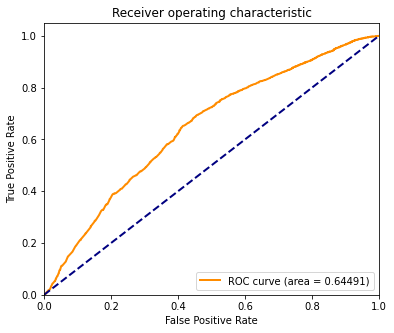

In [83]:
# x=pd.read_csv('./tmp/leave_one_process_out_k_10_m_1000_n_20.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_k_10_nb_100_bna_10_draw_objects_mk2.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_k_40_bireducts_1000_sample_attrs_100_max_attrs_10.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_same_category_bireducts_1_sample_attrs_100_max_attrs_100.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_same_category_bireducts_1000_sample_attrs_100_max_attrs_20.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_same_category_bireducts_1000_sample_attrs_200_max_attrs_30.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_k_40_bireducts_1000_candidate_attrs_50_max_attrs_30_eps_0.2_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_100_candidate_attrs_20_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_100_candidate_attrs_20_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_100_candidate_attrs_20_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_30_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_500_candidate_attrs_30_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_draw_uni_dec_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_draw_uni_dec_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_draw_uni_dec_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')


# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.1_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')

####
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.1_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')


# fpr, tpr, _ = roc_curve(df_dec, np.nan_to_num(x[0]/x[1]))
fpr, tpr, _ = roc_curve(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1]), pos_label=1)

plt.figure(figsize=(6, 5))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.5f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [23]:
import re
from collections import defaultdict

import seaborn as sns

In [20]:
result = []
for p in (TMP_DIR).glob("*.csv"):
    m = re.search(r"k_(\d+)", p.name)
    if m is None:
        continue
    k = int(m.group(1))
    x = pd.read_csv(p, sep=";")
    result.append(
        [k, roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1]))]
    )
result = pd.DataFrame(result, columns=("k", "AUC"))

NameError: name 'TMP_DIR' is not defined

<AxesSubplot:xlabel='k', ylabel='AUC'>

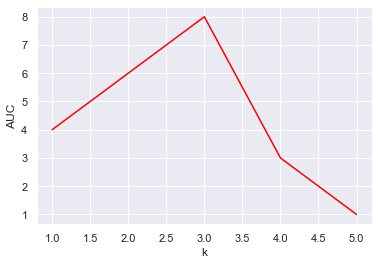

In [64]:
x = pd.DataFrame({"k": [1, 2, 3, 4, 5], "AUC": [4, 6, 8, 3, 1]})
sns.lineplot(data=x, x="k", y="AUC", color=("red"))

In [40]:
p.set_xlim([])

<bound method _AxesBase.set_xlim of <AxesSubplot:xlabel='k', ylabel='AUC'>>

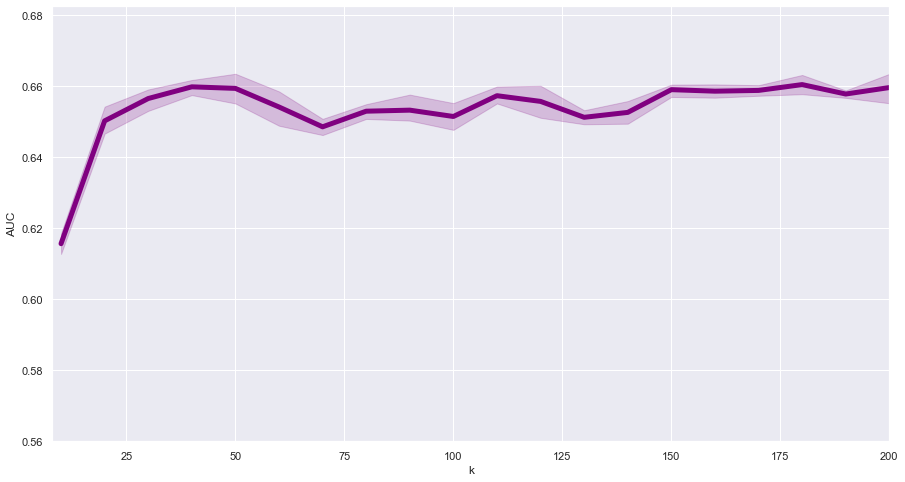

In [71]:
sns.set_theme()
plt.figure(figsize=(15, 8))
plt.xlim(8, 200)
p = sns.lineplot(data=result, x="k", y="AUC", lw=5, color="purple")
p.axes.set_ylim([0.56, 0.6825])
p.figure.savefig("a.pdf")

In [74]:
result[result["k"] == 10]["AUC"].mean()

0.6156635613828424